# Fine-tune SentenceTransformer Models for ITSM Tickets (v3)
Self-contained pipeline to train a similarity model and (optionally) a relationship classifier.

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import math
import random
import logging
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader

from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from transformers import TrainerControl

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


/opt/anaconda3/envs/itsm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports successful
PyTorch version: 2.9.1
Device: CPU


## 2. Configuration

In [2]:

# Base configuration (override as needed)
CONFIG = {
    'base_model': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/all-mpnet-finetuned',
    'source_data': 'data/dumm_data_promax.csv',
    'epochs': 8,  # Reduced from 12
    'batch_size': 16,  # Reduced from 32 for more gradient updates
    'learning_rate': 1e-5,  # Lowered from 2e-5 to reduce overfitting
    'warmup_steps': 200,  # Increased from 100 for stability
    'eval_split': 0.15,  # Slightly smaller eval set = more training data
    'max_seq_length': 256,
    'eval_steps': 50,  # Evaluate more frequently
}

# Derived paths (ensure plain string path)
output_dir_str = str(CONFIG['output_dir'])
output_path = output_dir_str if os.path.isabs(output_dir_str) else os.path.join(os.getcwd(), output_dir_str)
os.makedirs(output_path, exist_ok=True)
print(f"Output directory: {output_path}")


Output directory: /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned


## 3. Load Training Data (dummy_data_promax)


In [3]:

# Build training pairs directly from dummy_data_promax.csv
from itertools import combinations

raw_data_path = CONFIG.get('source_data') or os.path.join('data', 'dumm_data_promax.csv')
if not os.path.isabs(raw_data_path):
    raw_data_path = os.path.join(os.getcwd(), raw_data_path)

if not os.path.exists(raw_data_path):
    raise FileNotFoundError(f"Expected input data at {raw_data_path}. Ensure dummy_data_promax is available.")

required_columns = ["Number", "Short Description", "Description", "Category", "Subcategory"]
df = pd.read_csv(raw_data_path)
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing expected columns in {raw_data_path}: {missing_columns}")

# Normalize text fields to align with the new headers
for col in ["Short Description", "Description"]:
    df[col] = df[col].fillna("").astype(str).str.strip()
for col in ["Category", "Subcategory"]:
    df[col] = df[col].fillna("Unknown").astype(str).str.strip()

# Combine short description and description for the embedding text
combined_text = (df["Short Description"] + ". " + df["Description"]).str.strip()
combined_text = combined_text.str.replace(r'^\.\s*', '', regex=True)
df["text"] = combined_text

print(f"Loaded {len(df)} incidents from {raw_data_path}")
print("Columns used:", required_columns)
print(df[required_columns].head(3))

positive_pairs = []
max_pairs_per_category = 200
random.seed(42)

for category, group in df.groupby("Category"):
    idxs = list(group.index)
    if len(idxs) < 2:
        continue
    combos = list(combinations(idxs, 2))
    random.shuffle(combos)
    for idx1, idx2 in combos[:max_pairs_per_category]:
        row1 = df.loc[idx1]
        row2 = df.loc[idx2]
        positive_pairs.append({
            "ticket1_id": row1["Number"],
            "ticket2_id": row2["Number"],
            "text1": row1["text"],
            "text2": row2["text"],
            "category1": row1["Category"],
            "category2": row2["Category"],
            "subcategory1": row1["Subcategory"],
            "subcategory2": row2["Subcategory"],
        })

if not positive_pairs:
    raise ValueError("No positive pairs could be created; check category distribution in the dataset.")

all_indices = list(df.index)

def create_hard_negatives(df, target_count, seed=42):
    """
    Create hard negatives that share some keywords but different categories.
    This makes the model learn finer distinctions.
    """
    random.seed(seed)
    negatives = []
    attempts = 0
    max_attempts = target_count * 20

    # Group by category
    category_groups = {cat: group for cat, group in df.groupby("Category")}
    categories = list(category_groups.keys())

    while len(negatives) < target_count and attempts < max_attempts:
        attempts += 1

        # Pick two different categories
        cat1, cat2 = random.sample(categories, 2)

        # Sample incidents from each
        idx1 = random.choice(category_groups[cat1].index)
        idx2 = random.choice(category_groups[cat2].index)

        row1 = df.loc[idx1]
        row2 = df.loc[idx2]

        # Calculate keyword overlap to prefer hard negatives
        words1 = set(row1['text'].lower().split())
        words2 = set(row2['text'].lower().split())
        overlap = len(words1 & words2) / max(len(words1), len(words2))

        # Prefer pairs with some overlap (hard negatives)
        # but not too much (would be confusing)
        if 0.1 < overlap < 0.4:
            negatives.append({
                "ticket1_id": row1["Number"],
                "ticket2_id": row2["Number"],
                "text1": row1["text"],
                "text2": row2["text"],
                "category1": row1["Category"],
                "category2": row2["Category"],
                "subcategory1": row1["Subcategory"],
                "subcategory2": row2["Subcategory"],
            })

    # If we didn't get enough hard negatives, fill with random ones
    while len(negatives) < target_count:
        i, j = random.sample(all_indices, 2)
        if df.at[i, "Category"] != df.at[j, "Category"]:
            row1, row2 = df.loc[i], df.loc[j]
            negatives.append({
                "ticket1_id": row1["Number"],
                "ticket2_id": row2["Number"],
                "text1": row1["text"],
                "text2": row2["text"],
                "category1": row1["Category"],
                "category2": row2["Category"],
                "subcategory1": row1["Subcategory"],
                "subcategory2": row2["Subcategory"],
            })

    return negatives

negative_pairs = create_hard_negatives(df, len(positive_pairs), seed=42)
print(f"Created {len(negative_pairs)} hard negative pairs")

print(f"Loaded pairs from {os.path.basename(raw_data_path)}: {len(positive_pairs)} positive, {len(negative_pairs)} negative")


Loaded 10000 incidents from /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/data/dumm_data_promax.csv
Columns used: ['Number', 'Short Description', 'Description', 'Category', 'Subcategory']
       Number                                  Short Description  \
0  INC9000000  Request: Adjust Configuration/Program bug conf...   
1  INC9000001  Request: Adjust Configuration/Integration conf...   
2  INC9000002  Error in Mulesoft/EAI (FICO - Finance & Contro...   

                                         Description       Category  \
0  I encountered an issue where Request: Adjust C...  Configuration   
1  I encountered an issue where Request: Adjust C...  Configuration   
2  There appears to be a problem related to Error...  Configuration   

   Subcategory  
0  Program bug  
1  Integration  
2       Report  
Created 1400 hard negative pairs
Loaded pairs from dumm_data_promax.csv: 1400 positive, 1400 negative


## 3.5 Data Augmentation (Optional)
Augment training data to increase diversity and reduce overfitting.


In [4]:

# New Section 3.5: Data Augmentation (Optional)
"""
Augment training data to increase diversity and reduce overfitting.
"""

def augment_text_simple(text, aug_ratio=0.3):
    """
    Simple augmentation: randomly drop/shuffle words
    More sophisticated augmentation requires nlpaug library
    """
    words = text.split()
    if len(words) < 4:
        return text

    # Randomly drop words (keep at least 70% of words)
    keep_count = max(3, int(len(words) * (1 - aug_ratio)))
    if random.random() > 0.5 and len(words) > keep_count:
        indices = sorted(random.sample(range(len(words)), keep_count))
        words = [words[i] for i in indices]

    return ' '.join(words)

# Augment 20% of positive pairs
augment_count = int(len(positive_pairs) * 0.2)
augmented_pairs = []

for pair in random.sample(positive_pairs, augment_count):
    augmented_pairs.append({
        "ticket1_id": pair["ticket1_id"] + "_aug",
        "ticket2_id": pair["ticket2_id"],
        "text1": augment_text_simple(pair["text1"]),
        "text2": pair["text2"],
        "category1": pair["category1"],
        "category2": pair["category2"],
        "subcategory1": pair["subcategory1"],
        "subcategory2": pair["subcategory2"],
    })

positive_pairs.extend(augmented_pairs)
print(f"Added {len(augmented_pairs)} augmented positive pairs")
print(f"Total positive pairs: {len(positive_pairs)}")


Added 280 augmented positive pairs
Total positive pairs: 1680


## 4. Create Training Examples

In [5]:
# Build InputExamples for MultipleNegativesRankingLoss
random.shuffle(positive_pairs)
split_idx = int(len(positive_pairs) * (1 - CONFIG['eval_split']))
train_positive_pairs = positive_pairs[:split_idx]
eval_positive_pairs = positive_pairs[split_idx:]

train_examples = [InputExample(texts=[pair['text1'], pair['text2']]) for pair in train_positive_pairs]

eval_examples = []
for pair in eval_positive_pairs:
    eval_examples.append(InputExample(texts=[pair['text1'], pair['text2']], label=1.0))
for pair in negative_pairs:
    eval_examples.append(InputExample(texts=[pair['text1'], pair['text2']], label=0.0))

random.shuffle(eval_examples)

print(f"Created {len(train_examples)} training examples for MultipleNegativesRankingLoss")
print("📊 Data Split:")
print(f"  Training positives: {len(train_examples)} examples")
print(f"  Evaluation positives: {len(eval_positive_pairs)} examples")
print(f"  Evaluation negatives: {len(negative_pairs)} examples")
if len(eval_examples) < 25:
    print("⚠️ Eval set is small; metrics may be noisy. Consider adding more data or increasing eval_split.")


Created 1428 training examples for MultipleNegativesRankingLoss
📊 Data Split:
  Training positives: 1428 examples
  Evaluation positives: 252 examples
  Evaluation negatives: 1400 examples


## 5. Load Base Model

In [6]:
print(f"Loading base model: {CONFIG['base_model']}")
model = SentenceTransformer(CONFIG['base_model'])
model.max_seq_length = CONFIG['max_seq_length']
print("✅ Model loaded successfully")
print(f"Max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")


2025-11-29 14:59:48,941 - INFO - Use pytorch device_name: mps
2025-11-29 14:59:48,942 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


Loading base model: sentence-transformers/all-mpnet-base-v2
✅ Model loaded successfully
Max sequence length: 256
Embedding dimension: 768


## 6. Setup Training Components

In [7]:
# DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONFIG['batch_size'])

# Loss
train_loss = losses.MultipleNegativesRankingLoss(model)

# Evaluator (only if we have eval data)
evaluator = None
if eval_examples:
    eval_sents1 = [ex.texts[0] for ex in eval_examples]
    eval_sents2 = [ex.texts[1] for ex in eval_examples]
    eval_scores = [ex.label for ex in eval_examples]
    evaluator = EmbeddingSimilarityEvaluator(eval_sents1, eval_sents2, eval_scores)
    print(f"Evaluator initialized with {len(eval_examples)} examples")
else:
    print("No eval examples; skipping evaluator setup")

class EarlyStoppingCallback:
    """Stop training when performance stops improving"""
    def __init__(self, patience=2, min_delta=0.01, monitor='spearman'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.best_score = None
        self.counter = 0
        self.best_model_path = None

    def __call__(self, score, epoch, steps):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            logger.info(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                logger.info(f"Early stopping triggered at epoch {epoch}")
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

early_stop_callback = EarlyStoppingCallback(patience=2, min_delta=0.01)


Evaluator initialized with 1652 examples


In [ ]:
from transformers.trainer_callback import TrainerControl

## 7. Train the Model

In [16]:
print(f"Warmup steps: {CONFIG['warmup_steps']}")
from transformers.trainer_callback import TrainerControl
print(f"{'='*60}")
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

training_log = {
    'epoch_scores': [],
    'best_epoch': 0,
    'best_score': 0
}

class LoggingCallback:
    """Log training progress"""
    def __call__(self, score, epoch, steps):
        training_log['epoch_scores'].append({
            'epoch': epoch,
            'steps': steps,
            'score': score
        })
        if score > training_log['best_score']:
            training_log['best_score'] = score
            training_log['best_epoch'] = epoch

        print(f"\n📊 Epoch {epoch} - Score: {score:.4f} (Best: {training_log['best_score']:.4f} @ Epoch {training_log['best_epoch']})")

        # Check early stopping
        if early_stop_callback(score, epoch, steps):
            print("\n⚠️  Early stopping triggered!")
            control = TrainerControl()
            control.should_training_stop = True
            return control

        return TrainerControl()
logging_callback = LoggingCallback()

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=CONFIG['epochs'],
    warmup_steps=CONFIG['warmup_steps'],
    output_path=output_path,
    evaluation_steps=CONFIG['eval_steps'],
    callback=logging_callback,
    show_progress_bar=True,
)

print(f"{'='*60}")
print("Training completed!")
print(f"Best epoch: {training_log['best_epoch']} with score: {training_log['best_score']:.4f}")
print(f"{'='*60}")


Warmup steps: 200
Starting training at 2025-11-29 15:52:41


/opt/anaconda3/envs/itsm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
50,No log,No log,0.511563,0.473736
90,No log,No log,0.538321,0.476592
100,No log,No log,0.542523,0.485369
150,No log,No log,0.589450,0.499278
180,No log,No log,0.563427,0.493031
200,No log,No log,0.595460,0.498964


2025-11-29 15:53:41,720 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 0.5555555555555556 after 50 steps:
2025-11-29 15:54:11,791 - INFO - Cosine-Similarity:	Pearson: 0.5116	Spearman: 0.4737
2025-11-29 15:54:11,793 - INFO - Early stopping counter: 1/2



📊 Epoch 0.5555555555555556 - Score: 0.4737 (Best: 0.4737 @ Epoch 0.5555555555555556)


2025-11-29 15:54:11,794 - INFO - Save model to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned
2025-11-29 15:55:00,546 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 1.0 after 90 steps:
2025-11-29 15:55:30,396 - INFO - Cosine-Similarity:	Pearson: 0.5383	Spearman: 0.4766



📊 Epoch 1.0 - Score: 0.4766 (Best: 0.4766 @ Epoch 1.0)


2025-11-29 15:55:30,400 - INFO - Save model to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned
2025-11-29 15:55:43,403 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 1.1111111111111112 after 100 steps:
2025-11-29 15:56:16,457 - INFO - Cosine-Similarity:	Pearson: 0.5425	Spearman: 0.4854
2025-11-29 15:56:16,459 - INFO - Early stopping counter: 1/2



📊 Epoch 1.1111111111111112 - Score: 0.4854 (Best: 0.4854 @ Epoch 1.1111111111111112)


2025-11-29 15:56:16,460 - INFO - Save model to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned
2025-11-29 15:57:30,189 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 1.6666666666666665 after 150 steps:
2025-11-29 15:58:07,218 - INFO - Cosine-Similarity:	Pearson: 0.5895	Spearman: 0.4993



📊 Epoch 1.6666666666666665 - Score: 0.4993 (Best: 0.4993 @ Epoch 1.6666666666666665)


2025-11-29 15:58:07,220 - INFO - Save model to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned
2025-11-29 15:58:55,322 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 2.0 after 180 steps:
2025-11-29 15:59:29,483 - INFO - Cosine-Similarity:	Pearson: 0.5634	Spearman: 0.4930
2025-11-29 15:59:29,487 - INFO - Early stopping counter: 1/2



📊 Epoch 2.0 - Score: 0.4930 (Best: 0.4993 @ Epoch 1.6666666666666665)


2025-11-29 15:59:58,136 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 2.2222222222222223 after 200 steps:
2025-11-29 16:00:33,925 - INFO - Cosine-Similarity:	Pearson: 0.5955	Spearman: 0.4990
2025-11-29 16:00:33,927 - INFO - Early stopping counter: 2/2
2025-11-29 16:00:33,928 - INFO - Early stopping triggered at epoch 2.2222222222222223



📊 Epoch 2.2222222222222223 - Score: 0.4990 (Best: 0.4993 @ Epoch 1.6666666666666665)

⚠️  Early stopping triggered!


2025-11-29 16:00:33,929 - INFO - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 2.2222222222222223 after 200 steps:
2025-11-29 16:01:10,303 - INFO - Cosine-Similarity:	Pearson: 0.5955	Spearman: 0.4990
2025-11-29 16:01:10,306 - INFO - Early stopping counter: 3/2
2025-11-29 16:01:10,306 - INFO - Early stopping triggered at epoch 2.2222222222222223



📊 Epoch 2.2222222222222223 - Score: 0.4990 (Best: 0.4993 @ Epoch 1.6666666666666665)

⚠️  Early stopping triggered!
Training completed!
Best epoch: 1.6666666666666665 with score: 0.4993


## 8. Save Training Metadata

In [17]:

metadata = {
    "base_model": CONFIG['base_model'],
    "source_data": CONFIG.get('source_data'),
    "training_date": datetime.now().isoformat(),
    "epochs": CONFIG['epochs'],
    "batch_size": CONFIG['batch_size'],
    "learning_rate": CONFIG['learning_rate'],
    "warmup_steps": CONFIG['warmup_steps'],
    "eval_split": CONFIG['eval_split'],
    "num_train_examples": len(train_examples),
    "num_eval_examples": len(eval_examples),
    "num_positive_pairs": len(positive_pairs),
    "num_negative_pairs": len(negative_pairs),
}

meta_path = os.path.join(output_path, 'training_metadata.json')
with open(meta_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to {meta_path}")


Metadata saved to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned/training_metadata.json


## 9. Quick Evaluation

In [18]:
# Simple cosine similarity check on the first eval pair (if available)
if eval_examples:
    sample = eval_examples[0]
    emb1 = model.encode(sample.texts[0])
    emb2 = model.encode(sample.texts[1])
    from sklearn.metrics.pairwise import cosine_similarity
    sim = float(cosine_similarity([emb1], [emb2])[0][0])
    print("Example eval pair similarity:", sim, "(label:", sample.label, ")")
else:
    print("No eval examples available for quick check.")


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]

Example eval pair similarity: 0.7033624053001404 (label: 0.0 )


## 10. Load and Test Fine-tuned Model

In [19]:
# Reload from disk and run a quick inference
loaded_model = SentenceTransformer(output_path)
example_a = "User cannot log into SAP after maintenance"
example_b = "SAP authentication error following system reboot"
emb_a = loaded_model.encode(example_a)
emb_b = loaded_model.encode(example_b)
from sklearn.metrics.pairwise import cosine_similarity
sim = float(cosine_similarity([emb_a], [emb_b])[0][0])
print("Example similarity:", sim)


2025-11-29 16:02:25,068 - INFO - Use pytorch device_name: mps
2025-11-29 16:02:25,068 - INFO - Load pretrained SentenceTransformer: /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned
Batches: 100%|██████████| 1/1 [00:00<00:00, 76.01it/s]

Example similarity: 0.8065882921218872


## 11. (Optional) Relationship Classifier

In [22]:
# Train a simple classifier on labeled relationship pairs if available
rel_json_path = os.path.join('data', 'relationship_pairs.json')
if not os.path.exists(rel_json_path):
    print(f"relationship_pairs.json not found at {rel_json_path}. Skip this section if you don't need it.")
else:
    with open(rel_json_path, 'r', encoding='utf-8') as f:
        rel_data = json.load(f)
    df_pairs = pd.DataFrame(rel_data)
    valid_labels = ["duplicate", "related", "causal", "none"]
    df_pairs = df_pairs[df_pairs['label'].isin(valid_labels)].reset_index(drop=True)
    if df_pairs.empty:
        raise ValueError("No valid relationship data found.")

    # Check class distribution
    print("Original class distribution:")
    print(df_pairs['label'].value_counts())

    # Balance classes by undersampling majority class
    min_class_size = df_pairs['label'].value_counts().min()
    print(f"Balancing to {min_class_size} samples per class...")

    balanced_dfs = []
    for label in valid_labels:
        label_df = df_pairs[df_pairs['label'] == label]
        if len(label_df) > min_class_size:
            label_df = resample(label_df, n_samples=min_class_size, random_state=42)
        balanced_dfs.append(label_df)

    df_pairs = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced class distribution:")
    print(df_pairs['label'].value_counts())

    texts_a = df_pairs['text_a'].astype(str).tolist()
    texts_b = df_pairs['text_b'].astype(str).tolist()
    y_labels = df_pairs['label'].tolist()

    rel_embedder = SentenceTransformer(output_path)
    emb_a = rel_embedder.encode(texts_a, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
    emb_b = rel_embedder.encode(texts_b, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

    def build_pair_features(emb_a, emb_b):
        diff = np.abs(emb_a - emb_b)
        prod = emb_a * emb_b
        return np.hstack([emb_a, emb_b, diff, prod])

    X = build_pair_features(emb_a, emb_b)
    label2id = {lbl: i for i, lbl in enumerate(valid_labels)}
    id2label = {i: lbl for lbl, i in label2id.items()}
    y = np.array([label2id[lbl] for lbl in y_labels])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs', n_jobs=-1, class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    labels_order = list(label2id.values())
    label_names_ordered = [id2label[i] for i in labels_order]

    print("Relationship classifier report:")
    print(classification_report(y_val, y_pred, labels=labels_order, target_names=label_names_ordered, zero_division=0))
    print("Confusion matrix:")
    print(confusion_matrix(y_val, y_pred, labels=labels_order))

    rel_dir = os.path.join(output_path, 'relationship_classifier')
    os.makedirs(rel_dir, exist_ok=True)
    import joblib
    joblib.dump(clf, os.path.join(rel_dir, 'relationship_classifier.joblib'))
    with open(os.path.join(rel_dir, 'label_mapping.json'), 'w') as f:
        json.dump({'label2id': label2id, 'id2label': id2label}, f, indent=2)
    print(f"Saved relationship classifier to {rel_dir}")


2025-11-29 16:02:56,107 - INFO - Use pytorch device_name: mps
2025-11-29 16:02:56,107 - INFO - Load pretrained SentenceTransformer: /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned


Original class distribution:
label
none         152
related       37
duplicate      2
Name: count, dtype: int64
Balancing to 2 samples per class...
Balanced class distribution:
label
duplicate    2
none         2
related      2
Name: count, dtype: int64


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s]


ValueError: The test_size = 2 should be greater or equal to the number of classes = 3

# 11 Relationship Classifier fixed

In [25]:
# Train a simple classifier on labeled relationship pairs if available
rel_json_path = os.path.join('data', 'relationship_pairs.json')
if not os.path.exists(rel_json_path):
    print(f"relationship_pairs.json not found at {rel_json_path}. Skip this section if you don't need it.")
else:
    with open(rel_json_path, 'r', encoding='utf-8') as f:
        rel_data = json.load(f)
    df_pairs = pd.DataFrame(rel_data)

    # --- Start of fix ---
    # Check original distribution and filter out classes too small for a stratified split
    print("Original class distribution:")
    class_counts = df_pairs['label'].value_counts()
    print(class_counts)

    # We need at least 2 samples per class to even consider splitting.
    # For a 0.2 test split, we need at least 1/0.2 = 5 samples for a robust split.
    MIN_SAMPLES = 5 
    labels_to_keep = class_counts[class_counts >= MIN_SAMPLES].index.tolist()
    if len(labels_to_keep) < 2:
        print(f"\n⚠️ Skipping relationship classifier: Not enough classes with at least {MIN_SAMPLES} samples to train a classifier.")
    else:
        print(f"\nUsing labels with at least {MIN_SAMPLES} samples: {labels_to_keep}")
        df_pairs = df_pairs[df_pairs['label'].isin(labels_to_keep)].reset_index(drop=True)
 
        # Balance classes by undersampling majority classes to the size of the smallest
        min_class_size = df_pairs['label'].value_counts().min()
        print(f"\nBalancing to {min_class_size} samples per class...")

        balanced_dfs = []
        for label in labels_to_keep:
            label_df = df_pairs[df_pairs['label'] == label]
            # We only downsample; we don't upsample in this logic
            if len(label_df) > min_class_size:
                label_df = resample(label_df, n_samples=min_class_size, random_state=42, replace=False)
            balanced_dfs.append(label_df)
        df_pairs = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
        
        print("\nBalanced class distribution:")
        print(df_pairs['label'].value_counts())
        
        texts_a = df_pairs['text_a'].astype(str).tolist()
        texts_b = df_pairs['text_b'].astype(str).tolist()
        y_labels = df_pairs['label'].tolist()
 
        rel_embedder = SentenceTransformer(output_path)
        emb_a = rel_embedder.encode(texts_a, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
        emb_b = rel_embedder.encode(texts_b, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

        def build_pair_features(emb_a, emb_b):
            diff = np.abs(emb_a - emb_b)
            prod = emb_a * emb_b
            return np.hstack([emb_a, emb_b, diff, prod])

        X = build_pair_features(emb_a, emb_b)
        label2id = {lbl: i for i, lbl in enumerate(labels_to_keep)}
        id2label = {i: lbl for lbl, i in label2id.items()}
        y = np.array([label2id[lbl] for lbl in y_labels])
        
        # Final check before splitting
        if len(y) * 0.2 < len(labels_to_keep):
              print(f"\n⚠️ Skipping relationship classifier: after balancing, the dataset is too small to be split into {len(labels_to_keep)} stratified classes.")
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

            clf = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs', n_jobs=-1, class_weight='balanced')
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_val)
            labels_order = list(label2id.values())
            label_names_ordered = [id2label[i] for i in labels_order]

            print("\nRelationship classifier report:")
            print(classification_report(y_val, y_pred, labels=labels_order, target_names=label_names_ordered, zero_division=0))
            print("\nConfusion matrix:")
            print(confusion_matrix(y_val, y_pred, labels=labels_order))
            rel_dir = os.path.join(output_path, 'relationship_classifier')
            os.makedirs(rel_dir, exist_ok=True)
             
            import joblib
            joblib.dump(clf, os.path.join(rel_dir, 'relationship_classifier.joblib'))
            with open(os.path.join(rel_dir, 'label_mapping.json'), 'w') as f:
                json.dump({'label2id': label2id, 'id2label': id2label}, f, indent=2)
            print(f"\nSaved relationship classifier to {rel_dir}")

2025-11-29 16:12:54,997 - INFO - Use pytorch device_name: mps
2025-11-29 16:12:54,997 - INFO - Load pretrained SentenceTransformer: /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned


Original class distribution:
label
none         152
related       37
duplicate      2
Name: count, dtype: int64

Using labels with at least 5 samples: ['none', 'related']

Balancing to 37 samples per class...

Balanced class distribution:
label
none       37
related    37
Name: count, dtype: int64


Batches: 100%|██████████| 3/3 [00:00<00:00,  8.75it/s]



Relationship classifier report:
              precision    recall  f1-score   support

        none       1.00      0.88      0.93         8
     related       0.88      1.00      0.93         7

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15


Confusion matrix:
[[7 1]
 [0 7]]

Saved relationship classifier to /Users/don/Documents/University/Current_Classes/Capstone/let_me_try_again/models/all-mpnet-finetuned/relationship_classifier


## 12. Visualize Metrics
Graphs for similarity eval and relationship classifier.

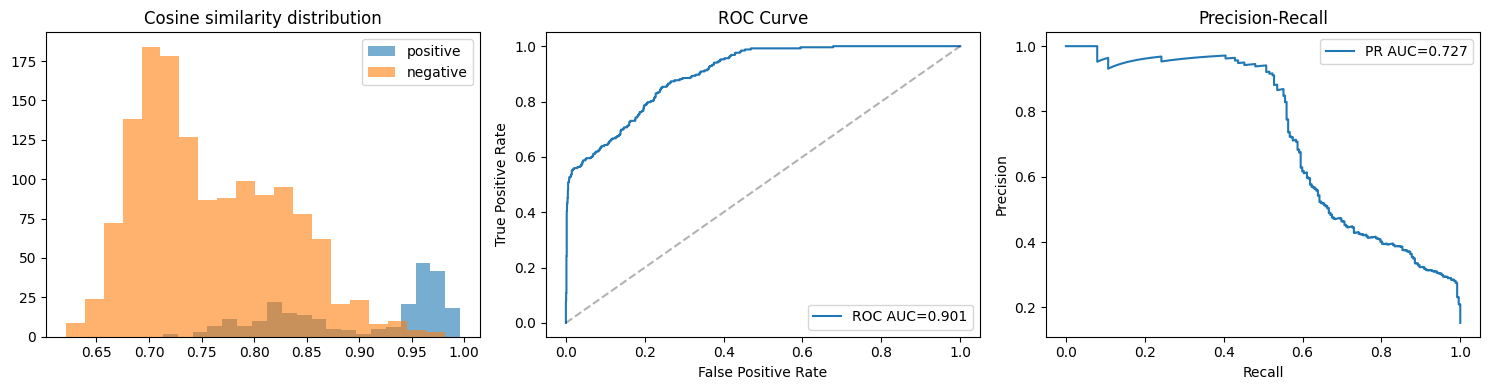

📈 Optimal Classification Threshold: 0.900
   F1 Score at threshold: 0.660
   Accuracy at threshold: 0.912


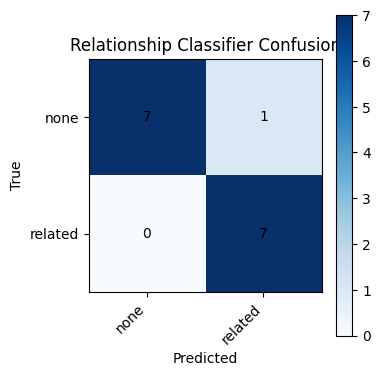

In [27]:
# Similarity evaluation plots
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

if not eval_examples:
    print('No eval examples; skipping similarity plots.')
else:
    eval_sents1 = [ex.texts[0] for ex in eval_examples]
    eval_sents2 = [ex.texts[1] for ex in eval_examples]
    labels = np.array([ex.label for ex in eval_examples])

    emb1 = model.encode(eval_sents1, convert_to_numpy=True, show_progress_bar=False)
    emb2 = model.encode(eval_sents2, convert_to_numpy=True, show_progress_bar=False)
    # cosine similarity
    norms1 = np.linalg.norm(emb1, axis=1)
    norms2 = np.linalg.norm(emb2, axis=1)
    cos_scores = np.sum(emb1 * emb2, axis=1) / (norms1 * norms2 + 1e-12)

    roc_auc = roc_auc_score(labels, cos_scores)
    pr_auc = average_precision_score(labels, cos_scores)
    fpr, tpr, _ = roc_curve(labels, cos_scores)
    precision, recall, _ = precision_recall_curve(labels, cos_scores)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(cos_scores[labels==1], bins=20, alpha=0.6, label='positive')
    axes[0].hist(cos_scores[labels==0], bins=20, alpha=0.6, label='negative')
    axes[0].set_title('Cosine similarity distribution')
    axes[0].legend()

    axes[1].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    axes[1].plot([0,1],[0,1],'k--', alpha=0.3)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()

    axes[2].plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Add threshold analysis
    thresholds = np.arange(0.3, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        preds = (cos_scores >= threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"📈 Optimal Classification Threshold: {best_threshold:.3f}")
    print(f"   F1 Score at threshold: {best_f1:.3f}")
    print(f"   Accuracy at threshold: {accuracy_score(labels, (cos_scores >= best_threshold).astype(int)):.3f}")

# Relationship classifier confusion matrix plot (if clf exists)
if 'clf' in globals() and 'label_names_ordered' in globals():
    cm = confusion_matrix(y_val, y_pred, labels=labels_order)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(label_names_ordered)))
    ax.set_xticklabels(label_names_ordered, rotation=45, ha='right')
    ax.set_yticks(range(len(label_names_ordered)))
    ax.set_yticklabels(label_names_ordered)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Relationship Classifier Confusion')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print('Relationship classifier not trained in this run; skipping confusion matrix plot.')
